$\newcommand{\ket}[1]{\left|#1\right\rangle}$
In this Jupyter notebook we implement a multicontrolled U-gate using Qiskit package.  Specifically for a given positive integer $n$ and a matrix $U \in \mathrm{U}(2)$ and outputs a quantum circuit on $n+1$ qubits, that implements a multi-controlled $U$ gate, $C^n U$, that is

$$
C^n U \ket{x}_n \ket{y}_1 = 
\begin{cases}
\ket{x}_n U \ket{y}_1, & \text{if } x = (1, 1, \dots, 1), \\
\ket{x}_n \ket{y}_1, & \text{otherwise}.
\end{cases}
$$

In [ ]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Operator
import numpy as np
from qiskit_aer import Aer
import matplotlib.pyplot as plt

In [3]:
# --- Helper function for ssingle-qubit U gate (equivalent to qc.u) ---
def apply_u_gate(qc, theta, phi, lambda_angle, qubit):
    qc.u(theta, phi, lambda_angle, qubit)

# --- 1. Controlled-U (CU) Gate Decomposition ---
def apply_cu(qc, control_qubit, target_qubit, theta, phi, lambda_angle):
    qc.u(0, 0, (lambda_angle + phi) / 2, control_qubit)
    qc.u(0, 0, (lambda_angle - phi) / 2, target_qubit)
    qc.cx(control_qubit, target_qubit)
    qc.u(-theta / 2, 0, -(phi + lambda_angle) / 2, target_qubit)
    qc.cx(control_qubit, target_qubit)
    qc.u(theta / 2, phi, 0, target_qubit)

# --- 2. Toffoli (CCX) Gate Decomposition ---
def apply_ccx(qc, control1, control2, target):
    qc.u(np.pi/2, 0, np.pi, target)
    qc.cx(control2, target)
    qc.u(0, 0, -np.pi/4, target)
    qc.cx(control1, target)
    qc.u(0, 0, np.pi/4, target)
    qc.cx(control2, target)
    qc.u(0, 0, -np.pi/4, target)
    qc.cx(control1, target)
    qc.u(0, 0, np.pi/4, control2)
    qc.u(0, 0, np.pi/4, target)
    qc.u(np.pi/2, 0, np.pi, target)
    qc.cx(control1, control2)
    qc.u(0, 0, np.pi/4, control1)
    qc.u(0, 0, -np.pi/4, control2)
    qc.cx(control1, control2)

# --- Multi-Controlled-U (CnU) Gate using Ancilla Ladder Method ---
def apply_multi_controlled_u_ancilla_ladder(qc, controls_list, target_q, ancillas_list, 
                                            theta, phi, lambda_angle): # Renamed for clarity
    num_controls = len(controls_list)
    if num_controls == 0:
        qc.u(theta, phi, lambda_angle, target_q)
    elif num_controls == 1:
        apply_cu(qc, controls_list[0], target_q, theta, phi, lambda_angle)
    else:
        if len(ancillas_list) < num_controls - 1:
            raise ValueError(f"Need {num_controls - 1} ancillas for {num_controls} controls, "
                             f"but got {len(ancillas_list)}.")
        apply_ccx(qc, controls_list[0], controls_list[1], ancillas_list[0])
        for i in range(2, num_controls):
            apply_ccx(qc, controls_list[i], ancillas_list[i-2], ancillas_list[i-1])
        
        control_for_u = ancillas_list[num_controls - 2]
        apply_cu(qc, control_for_u, target_q, theta, phi, lambda_angle)
        
        for i in range(num_controls - 1, 1, -1): 
            apply_ccx(qc, controls_list[i], ancillas_list[i-2], ancillas_list[i-1])
        apply_ccx(qc, controls_list[0], controls_list[1], ancillas_list[0])

Below we are visualizing a few examples

--- Visualizing U gate (0 controls) ---


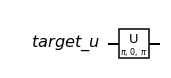


--- Visualizing CU gate (1 control) ---


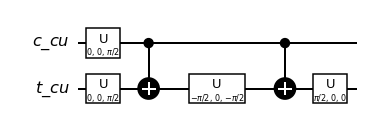


--- Visualizing C2U gate (2 controls, 1 ancilla) ---


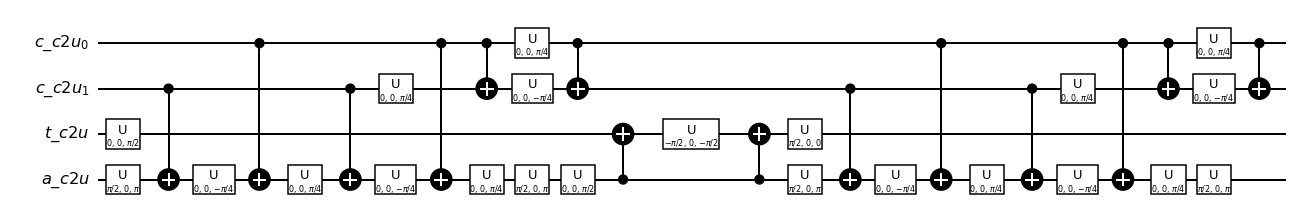


--- Visualizing C3U gate (3 controls, 2 ancillas) ---
C3U_X decomposed into 26 CNOTs and 40 U gates.


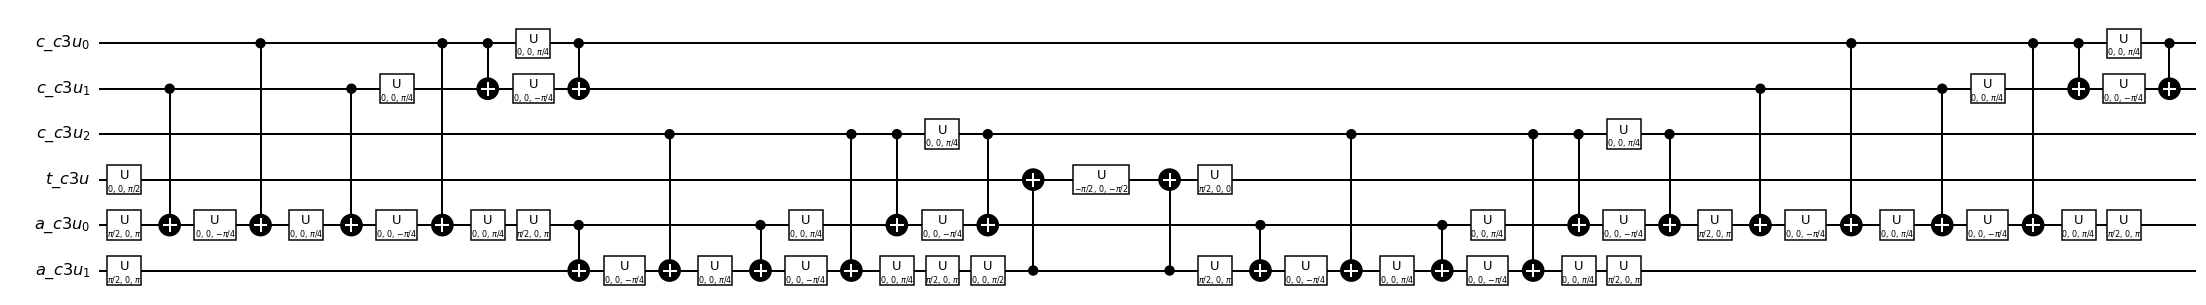


--- Visualizing C4U gate (4 controls, 3 ancillas) ---
C4U_X decomposed into 38 CNOTs and 58 U gates.


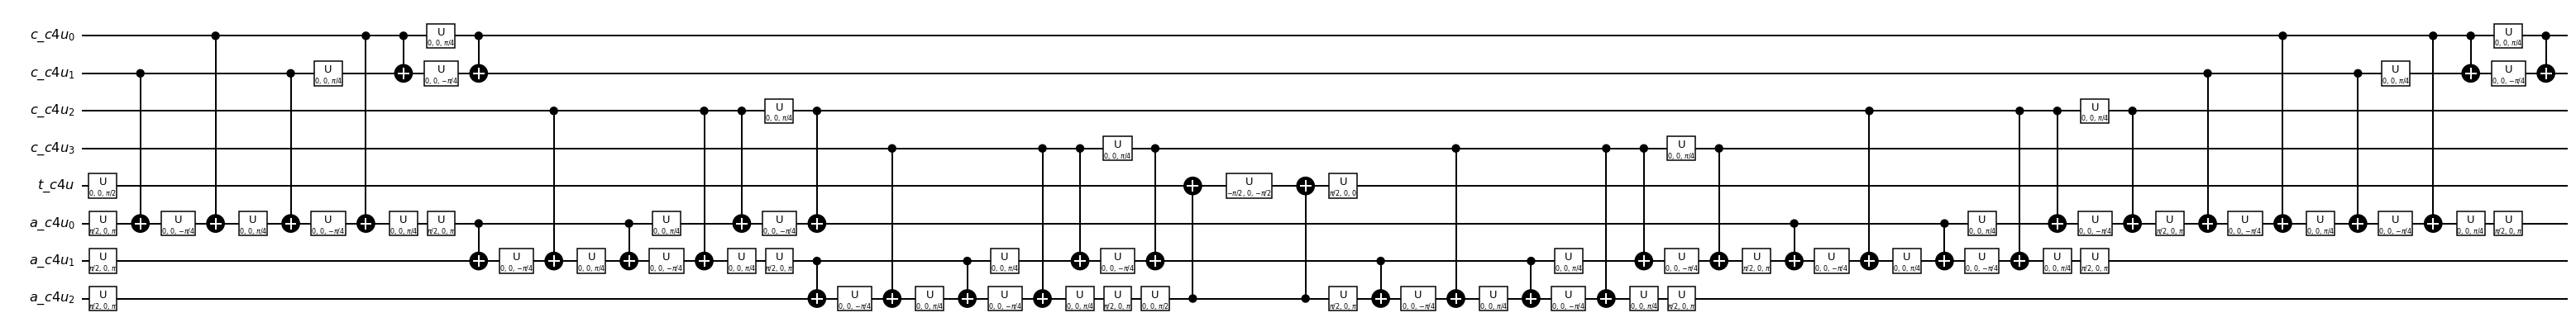


--- Visualizing and Verifying C3Z ---
Circuit for C^3Z with 2 ancillas prepared.


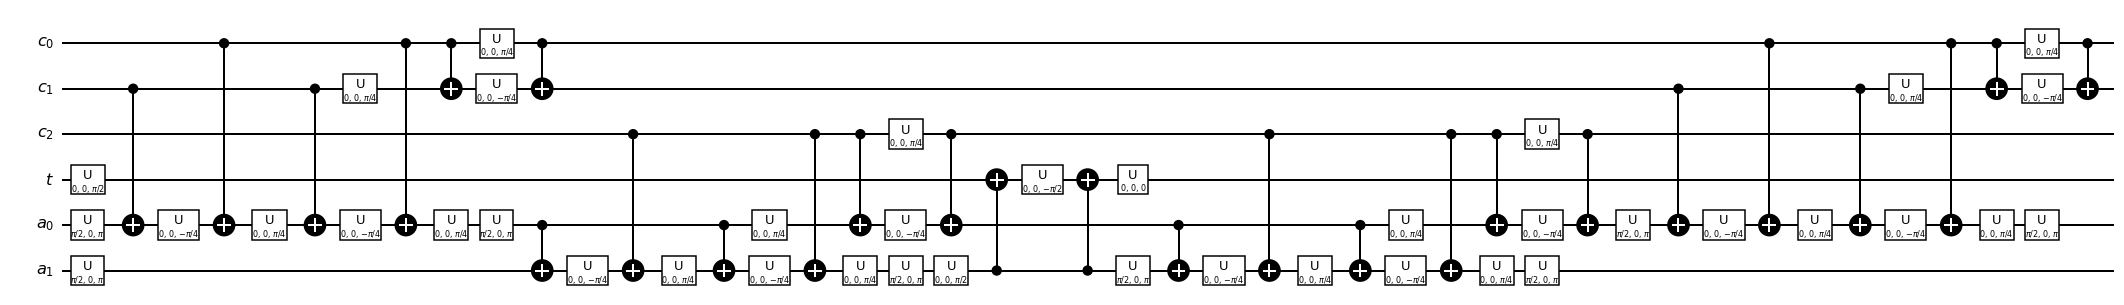

In [4]:

# --- Example Gate Visualizations ---
# Define the U gate parameters (e.g., for an X gate, U3(pi, 0, pi))
theta_U_example = np.pi 
phi_U_example = 0.0
lambda_U_example = np.pi

# --- Test C0U (just U) ---
print("--- Visualizing U gate (0 controls) ---")
q_c0u_target = QuantumRegister(1, 'target_u')
qc_c0u = QuantumCircuit(q_c0u_target, name="C0U_X")
apply_multi_controlled_u_ancilla_ladder(qc_c0u, [], q_c0u_target[0], [], 
                                        theta_U_example, phi_U_example, lambda_U_example)
display(qc_c0u.draw('mpl', style='bw')) # Using display() for Jupyter like environments
# To save: qc_c0u.draw('mpl', style='iqx').savefig("c0u_x.png")
plt.show() # May be needed in some script environments

# --- Test C1U (CU) ---
print("\n--- Visualizing CU gate (1 control) ---")
q_c1u_ctrl = QuantumRegister(1, 'c_cu')
q_c1u_target = QuantumRegister(1, 't_cu')
qc_c1u = QuantumCircuit(q_c1u_ctrl, q_c1u_target, name="C1U_X")
apply_multi_controlled_u_ancilla_ladder(qc_c1u, [q_c1u_ctrl[0]], q_c1u_target[0], [], 
                                        theta_U_example, phi_U_example, lambda_U_example)
display(qc_c1u.draw('mpl', style='bw'))
plt.show()

# --- Test C2U (CCU) ---
# Needs 2-1 = 1 ancilla
print("\n--- Visualizing C2U gate (2 controls, 1 ancilla) ---")
q_c2u_ctrl = QuantumRegister(2, 'c_c2u')
q_c2u_target = QuantumRegister(1, 't_c2u')
q_c2u_ancilla = QuantumRegister(1, 'a_c2u')
qc_c2u = QuantumCircuit(q_c2u_ctrl, q_c2u_target, q_c2u_ancilla, name="C2U_X")
apply_multi_controlled_u_ancilla_ladder(qc_c2u, 
                                       [q_c2u_ctrl[0], q_c2u_ctrl[1]], 
                                       q_c2u_target[0], 
                                       [q_c2u_ancilla[0]], 
                                       theta_U_example, phi_U_example, lambda_U_example)
display(qc_c2u.draw('mpl', style='bw', fold=-1))
plt.show()

# --- Test C3U (CCCU) ---
# Needs 3-1 = 2 ancillas
print("\n--- Visualizing C3U gate (3 controls, 2 ancillas) ---")
num_controls_c3u = 3
q_c3u_ctrl = QuantumRegister(num_controls_c3u, 'c_c3u')
q_c3u_target = QuantumRegister(1, 't_c3u')
q_c3u_ancilla = QuantumRegister(num_controls_c3u - 1, 'a_c3u')
qc_c3u = QuantumCircuit(q_c3u_ctrl, q_c3u_target, q_c3u_ancilla, name="C3U_X")
apply_multi_controlled_u_ancilla_ladder(qc_c3u, 
                                       [q_c3u_ctrl[i] for i in range(num_controls_c3u)], 
                                       q_c3u_target[0], 
                                       [q_c3u_ancilla[i] for i in range(num_controls_c3u - 1)], 
                                       theta_U_example, phi_U_example, lambda_U_example)
print(f"C3U_X decomposed into {qc_c3u.count_ops().get('cx', 0)} CNOTs "
      f"and {qc_c3u.count_ops().get('u', 0)} U gates.")
display(qc_c3u.draw('mpl', style='bw', fold=-1)) # fold=-1 to prevent subcircuit folding
plt.show()

# --- Test C4U ---
# Needs 4-1 = 3 ancillas
print("\n--- Visualizing C4U gate (4 controls, 3 ancillas) ---")
num_controls_c4u = 4
q_c4u_ctrl = QuantumRegister(num_controls_c4u, 'c_c4u')
q_c4u_target = QuantumRegister(1, 't_c4u')
q_c4u_ancilla = QuantumRegister(num_controls_c4u - 1, 'a_c4u') 
qc_c4u = QuantumCircuit(q_c4u_ctrl, q_c4u_target, q_c4u_ancilla, name="C4U_X")

control_qubits_list = [q_c4u_ctrl[i] for i in range(num_controls_c4u)]
ancilla_qubits_list = [q_c4u_ancilla[i] for i in range(num_controls_c4u - 1)]
target_qubit_obj = q_c4u_target[0]

apply_multi_controlled_u_ancilla_ladder(qc_c4u, control_qubits_list, target_qubit_obj, 
                                        ancilla_qubits_list, theta_U_example, phi_U_example, lambda_U_example)
print(f"C4U_X decomposed into {qc_c4u.count_ops().get('cx', 0)} CNOTs "
      f"and {qc_c4u.count_ops().get('u', 0)} U gates.")
# For very large circuits, drawing can be slow and the image very dense.
# Consider drawing with fold or only for smaller number of controls if it becomes unwieldy.
display(qc_c4u.draw('mpl', style='bw', fold=-1)) 
plt.show()


# --- Visualization and Unitary Verification for C3Z ---
print("\n--- Visualizing and Verifying C3Z ---")
num_controls_c3z = 3
num_ancillas_c3z = num_controls_c3z - 1

c_reg_z = QuantumRegister(num_controls_c3z, 'c')
t_reg_z = QuantumRegister(1, 't')
a_reg_z = QuantumRegister(num_ancillas_c3z, 'a')

qc_c3z = QuantumCircuit(c_reg_z, t_reg_z, a_reg_z, name="C3Z")

theta_Z = 0.0
phi_Z = 0.0
lambda_Z = np.pi # Z gate

controls_q_list_z = [c_reg_z[i] for i in range(num_controls_c3z)]
target_q_obj_z = t_reg_z[0]
ancillas_q_list_z = [a_reg_z[i] for i in range(num_ancillas_c3z)]

apply_multi_controlled_u_ancilla_ladder(qc_c3z, controls_q_list_z, target_q_obj_z, ancillas_q_list_z,
                                        theta_Z, phi_Z, lambda_Z)

print(f"Circuit for C^{num_controls_c3z}Z with {num_ancillas_c3z} ancillas prepared.")
display(qc_c3z.draw('mpl', style='bw', fold=-1))
plt.show()

Verifying C3Z

In [5]:
# --- Verification for C3Z (Corrected for DeprecationWarning) ---
num_controls_c3z = 3
num_ancillas_c3z = num_controls_c3z - 1

c_reg = QuantumRegister(num_controls_c3z, 'c')
t_reg = QuantumRegister(1, 't')
a_reg = QuantumRegister(num_ancillas_c3z, 'a')

qc_c3z = QuantumCircuit(c_reg, t_reg, a_reg, name="C3Z")

theta_Z = 0.0
phi_Z = 0.0
lambda_Z = np.pi

controls_q_list = [c_reg[i] for i in range(num_controls_c3z)]
target_q_obj = t_reg[0]
ancillas_q_list = [a_reg[i] for i in range(num_ancillas_c3z)]

apply_multi_controlled_u_ancilla_ladder(qc_c3z, controls_q_list, target_q_obj, ancillas_q_list,
                                        theta_Z, phi_Z, lambda_Z)

print(f"Circuit for C^{num_controls_c3z}Z with {num_ancillas_c3z} ancillas prepared.")
# display(qc_c3z.draw('mpl', style='iqx', fold=-1)) # Assuming display and plt.show() are handled
# plt.show()

print("Calculating unitary matrix for C3Z...")
unitary_backend = Aer.get_backend('unitary_simulator')

# Create a new circuit object for the simulator if you've already drawn the previous one
# This ensures the backend receives a 'fresh' circuit if drawing modified it (unlikely for unitary)
# Alternatively, ensure qc_c3z is not modified by drawing before simulation.
# For unitary_simulator, it's usually fine.
job = unitary_backend.run(qc_c3z)
result = job.result()

# Get the Operator object
operator_obj = result.get_unitary(qc_c3z)
# Explicitly convert to NumPy array to avoid deprecation warnings
unitary_matrix = np.asarray(operator_obj) 

print(f"Unitary matrix shape: {unitary_matrix.shape}") # Now uses NumPy array's shape

# Qubit order in state |q_N-1 ... q_0> (N=6 total qubits here)
# Circuit qubits qc_c3z.qubits: [c[0], c[1], c[2], t[0], a[0], a[1]]
# State is |a[1] a[0] t[0] c[2] c[1] c[0]> for matrix indexing.

idx1_str = "000111" # a1=0, a0=0, t0=0, c2=1, c1=1, c0=1
idx1 = int(idx1_str, 2) # 7

idx2_str = "001111" # a1=0, a0=0, t0=1, c2=1, c1=1, c0=1
idx2 = int(idx2_str, 2) # 15

idx3_str = "001011" # a1=0, a0=0, t0=1, c2=0, c1=1, c0=1
idx3 = int(idx3_str, 2) # 11

print(f"\n--- Verifying C3Z ---")
print(f"Qubit order for matrix indices (MSB to LSB): {qc_c3z.qubits}")
print(f"Consider computational basis states |a1 a0 t0 c2 c1 c0>")

# Accessing elements from the NumPy array
val1 = np.real(unitary_matrix[idx1, idx1])
print(f"\nInput |{idx1_str}> (Controls=111, Target=0, Ancillas=00):")
print(f"  Expected output: |{idx1_str}> (amplitude 1)")
print(f"  Matrix[idx1, idx1] = {val1:.2f}")

val2 = np.real(unitary_matrix[idx2, idx2])
print(f"\nInput |{idx2_str}> (Controls=111, Target=1, Ancillas=00):")
print(f"  Expected output: -|{idx2_str}> (amplitude -1)")
print(f"  Matrix[idx2, idx2] = {val2:.2f}")

val3 = np.real(unitary_matrix[idx3, idx3])
print(f"\nInput |{idx3_str}> (Controls=011, Target=1, Ancillas=00):")
print(f"  Expected output: |{idx3_str}> (amplitude 1)")
print(f"  Matrix[idx3, idx3] = {val3:.2f}")

print(f"  Matrix[idx1, idx2] (should be 0) = {unitary_matrix[idx1, idx2]:.2f}")
print(f"  Matrix[idx2, idx1] (should be 0) = {unitary_matrix[idx2, idx1]:.2f}")

print("\nSimplified check for the action on (controls, target) when ancillas are |00>:")
num_effective_qubits = num_controls_c3z + 1
sub_matrix_size = 2**num_effective_qubits

effective_unitary = unitary_matrix[0:sub_matrix_size, 0:sub_matrix_size]

# Indices for |t c2 c1 c0> within the sub-matrix:
# c0*1 + c1*2 + c2*4 + t*8
idx_eff_0111 = np.real(int("0111", 2)) # t=0, c2=1, c1=1, c0=1 (controls 111, target 0) -> 7
idx_eff_1111 = np.real(int("1111", 2)) # t=1, c2=1, c1=1, c0=1 (controls 111, target 1) -> 15
idx_eff_1011 = np.real(int("1011", 2)) # t=1, c2=0, c1=1, c0=1 (controls 011, target 1) -> 11


print(f"  Sub-matrix (ancillas kept at |00>) has shape: {effective_unitary.shape}")
print(f"  Element for (controls=111, target=0) -> (controls=111, target=0): M_eff[{idx_eff_0111},{idx_eff_0111}] = {effective_unitary[idx_eff_0111,idx_eff_0111]:.2f}")
print(f"  Element for (controls=111, target=1) -> (controls=111, target=1): M_eff[{idx_eff_1111},{idx_eff_1111}] = {effective_unitary[idx_eff_1111,idx_eff_1111]:.2f}")
print(f"  Element for (controls=011, target=1) -> (controls=011, target=1): M_eff[{idx_eff_1011},{idx_eff_1011}] = {effective_unitary[idx_eff_1011,idx_eff_1011]:.2f}")


Circuit for C^3Z with 2 ancillas prepared.
Calculating unitary matrix for C3Z...
Unitary matrix shape: (64, 64)

--- Verifying C3Z ---
Qubit order for matrix indices (MSB to LSB): [<Qubit register=(3, "c"), index=0>, <Qubit register=(3, "c"), index=1>, <Qubit register=(3, "c"), index=2>, <Qubit register=(1, "t"), index=0>, <Qubit register=(2, "a"), index=0>, <Qubit register=(2, "a"), index=1>]
Consider computational basis states |a1 a0 t0 c2 c1 c0>

Input |000111> (Controls=111, Target=0, Ancillas=00):
  Expected output: |000111> (amplitude 1)
  Matrix[idx1, idx1] = 1.00

Input |001111> (Controls=111, Target=1, Ancillas=00):
  Expected output: -|001111> (amplitude -1)
  Matrix[idx2, idx2] = -1.00

Input |001011> (Controls=011, Target=1, Ancillas=00):
  Expected output: |001011> (amplitude 1)
  Matrix[idx3, idx3] = 1.00
  Matrix[idx1, idx2] (should be 0) = 0.00+0.00j
  Matrix[idx2, idx1] (should be 0) = 0.00+0.00j

Simplified check for the action on (controls, target) when ancillas are 